Code for EE4540 Project assignment 

Standard imports

In [2]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import scipy.io as sio
from tqdm import tqdm

# Project Description

Consider the situation where we randomly place sensors in a square area of $100 \times 100 \ \mathrm{m}^2$ to measure a certain quantity (e.g., temperature, density, etc.).

---

### • Design of a Connected Sensor Network

Design a properly **connected sensor network** that covers the area of the plant using a reasonable number of sensors.

- **Task**: How many sensors are needed to guarantee a connected sensor network?
- **Deliverable**: Motivate and justify your choice based on theoretical or empirical reasoning.

---

### • Average Consensus

Suppose the sensor network aims to compute the **average** value of the measurement data.

- Implement a **randomised gossip algorithm** as a baseline method.
- Then, implement the **average consensus problem** using the **PDMM (Primal-Dual Method of Multipliers)** algorithm.
- **Report**: Compare the performance in terms of convergence speed and number of transmissions between the two algorithms.

---

### • Median Consensus

Suppose the sensor network now aims to compute the **median** of the measurement data.

- Implement the **median consensus problem** using the **PDMM algorithm**.


# Plot of the placed sensors in the area

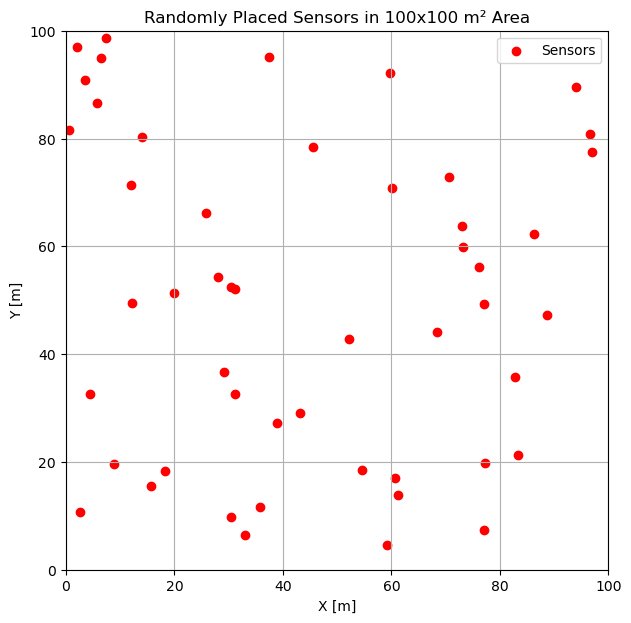

In [3]:
# Parameters
AREA_WIDTH = 100  # meters
NUM_SENSORS = 50  # Change this to your desired number of sensors
DIMENSION = 2

# Generate random sensor positions
np.random.seed(42)  # For reproducibility
coords = np.random.uniform(low = 0, high = AREA_WIDTH, size = (NUM_SENSORS, DIMENSION))

# Plot the grid and sensor positions
plt.figure(figsize=(7, 7))
plt.scatter(x = coords[:,0], y = coords[:,1], c='red', label='Sensors')
plt.xlim(0, AREA_WIDTH)
plt.ylim(0, AREA_WIDTH)
plt.title(f'Randomly Placed Sensors in {AREA_WIDTH}x{AREA_WIDTH} m² Area')
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.grid(True)
plt.legend()
plt.show()


# Connect the sensors that are close enough to each other

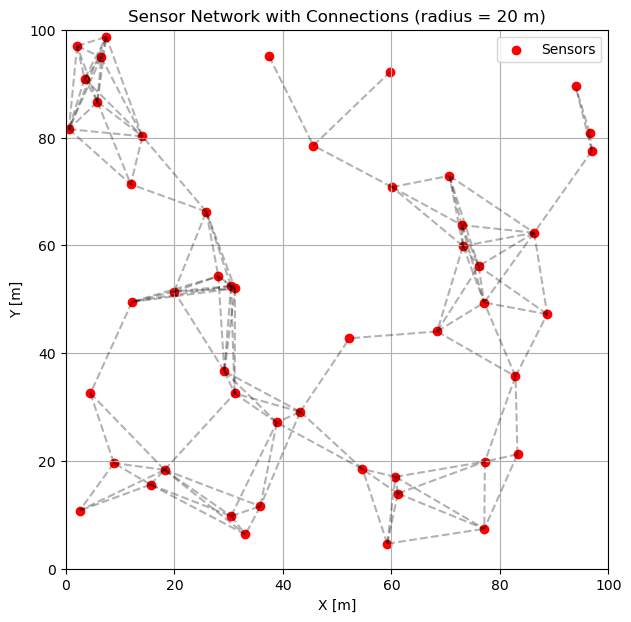

In [4]:
# Interconnect sensors that are within a certain communication radius
RADIUS = 20  # meters

plt.figure(figsize=(7, 7))
plt.scatter(x = coords[:,0], y = coords[:,1], c='red', label='Sensors')

# Vectorized computation of pairwise distances
dists = np.sqrt(np.sum((coords[:, None, :] - coords[None, :, :])**2, axis=-1))
adjacency = (dists <= RADIUS) & (dists > 0)

# Draw lines for all pairs within radius
for i in range(NUM_SENSORS):
    neighbors = np.where(adjacency[i])[0]
    for j in neighbors:
        if i < j:  # Avoid duplicate lines
            plt.plot([coords[i, 0], coords[j, 0]],
                     [coords[i, 1], coords[j, 1]],
                     'k--', alpha=0.3)

plt.xlim(0, AREA_WIDTH)
plt.ylim(0, AREA_WIDTH)
plt.title(f'Sensor Network with Connections (radius = {RADIUS} m)')
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.grid(True)
plt.legend()
plt.show()

A $d$-dimensional geometric random graph on $n$ nodes, denoted as $G^d(n, r)$, models a wireless ad-hoc network of nodes with wireless transmission radius $r$.

- Place $n$ nodes in a $d$-dimensional unit cube uniformly at random  
- Connect any two nodes that are within distance $r$ of each other  

---

### **Property:**

For $r^d \geq \dfrac{2 \log(n)}{n}$, the graph $G^d(n, r)$ is connected with probability at least  $1 - \dfrac{1}{n^2}$


In [5]:
DIMENSION = np.shape(coords)[1]  # Extract the number of dimensions

from helper import min_radius_for_sensors

# Calculate and print the minimum required radius
min_radius = min_radius_for_sensors(NUM_SENSORS, DIMENSION, AREA_WIDTH)


Minimum required radius for connectivity with high probability (n=50, area=100x100): 39.56 m


In [6]:
# Given a desired communication radius, calculate the minimum number of sensors for connectivity (with high probability)

DESIRED_RADIUS = 20  # meters, set your desired radius here
DIMENSION = np.shape(coords)[1]  # Number of dimensions (2D in this case)

from helper import min_sensors_for_radius

number_of_sensors = min_sensors_for_radius(DESIRED_RADIUS, AREA_WIDTH, DIMENSION)

Minimum number of sensors for radius 20 m: 283
Probability of connectivity with 283 sensors and radius 20 m: 99.9988%


# Randomized Gossip Implementation

### Add randomized data to the coordinate points

(50, 50)


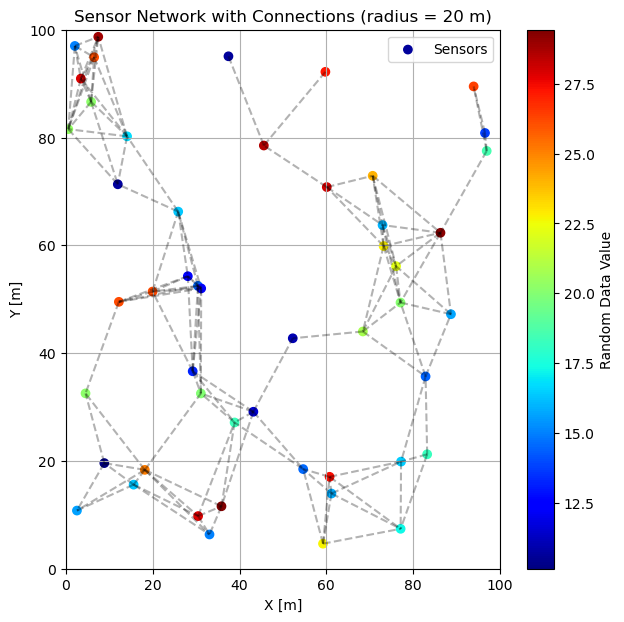

In [ ]:


# coords has shape (N, 2)
random_column = np.random.uniform(low=10, high=30, size=(coords.shape[0], 1))  # shape (N, 1)

# concatenate along axis=1 (columns)
coords_augmented = np.hstack((coords, random_column))  # shape (N, DIMENSION + 1)

# Compute pairwise distances
dists = np.sqrt(np.sum((coords_augmented[:, None, 0:2] - coords_augmented[None, :, 0:2])**2, axis=-1))

adjacency = (dists <= RADIUS) & (dists > 0)

# Create figure
plt.figure(figsize=(7, 7))

# Scatter plot with color based on random data
sc = plt.scatter(x = coords[:,0], y = coords[:,1], c=coords_augmented[:,2].flatten(), cmap='jet', label='Sensors')

# Draw dashed black lines for connected sensors
for i in range(NUM_SENSORS):
    neighbors = np.where(adjacency[i])[0]
    for j in neighbors:
        if i < j:  # Avoid duplicates
            plt.plot([coords[i, 0], coords[j, 0]],
                     [coords[i, 1], coords[j, 1]],
                     'k--', alpha=0.3)

# Add colorbar
cbar = plt.colorbar(sc)
cbar.set_label('Random Data Value')

# Final plot settings
plt.xlim(0, AREA_WIDTH)
plt.ylim(0, AREA_WIDTH)
plt.title(f'Sensor Network with Connections (radius = {RADIUS} m)')
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.grid(True)
plt.legend()
plt.show()



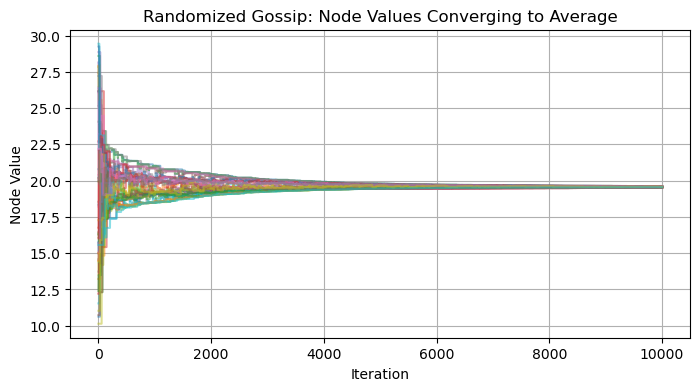

In [8]:
def randomized_gossip_average(adjacency, values, num_iters=1000, verbose=False):
    """
    Runs the randomized gossip algorithm to compute the average of the initial values.
    
    Parameters:
        adjacency: (N, N) boolean array, adjacency matrix of the network
        values: (N,) array, initial values at each node
        num_iters: int, number of gossip iterations
        verbose: bool, if True, prints progress
    
    Returns:
        history: list of arrays, value at each node after each iteration
    """
    N = len(values)
    x = values.copy()
    history = [x.copy()]
    for it in range(num_iters):
        # Randomly select an edge (i, j) from the adjacency matrix
        i = np.random.randint(N)
        neighbors = np.where(adjacency[i])[0]
        if len(neighbors) == 0:
            continue  # skip isolated node
        j = np.random.choice(neighbors)
        # Both nodes update to their average
        avg = 0.5 * (x[i] + x[j])
        x[i] = avg
        x[j] = avg
        history.append(x.copy())
        if verbose and it % 100 == 0:
            print(f"Iteration {it}: mean={np.mean(x):.4f}, std={np.std(x):.4f}")
    return history

# Initial values are the random data at each sensor
initial_values = coords_augmented[:, 2]

# Run the randomized gossip algorithm
gossip_history = randomized_gossip_average(adjacency, initial_values, num_iters=10000)

# Plot convergence of node values
plt.figure(figsize=(8, 4))
for i in range(NUM_SENSORS):
    plt.plot([x[i] for x in gossip_history], alpha=0.5)
plt.xlabel('Iteration')
plt.ylabel('Node Value')
plt.title('Randomized Gossip: Node Values Converging to Average')
plt.grid(True)
plt.show()